In [1]:
import sys

if 'ipykernel_launcher' in sys.argv[0]:
    sys.argv = [sys.argv[0]]

In [2]:
import os
import pandas as pd
import numpy as np

from tqdm import tqdm
from src.models import *
from src.constants import *
from src.plotting import *
from src.pot import pot_eval
from src.utils import *
from src.diagnosis import *
from src.merlin import *
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
from time import time
from pprint import pprint
import gc

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from captum.attr import IntegratedGradients

Using backend: pytorch


### Data loading

In [3]:
# Data folders
output_folder = 'processed'
data_folder = 'data'

In [4]:
def load_dataset(category, filename, dataset, dataset_folder):
    temp = np.genfromtxt(os.path.join(dataset_folder, category, filename),
                         dtype=np.float64,
                         delimiter=',')
    print(dataset, category, filename, temp.shape)
    return temp, temp.shape

In [5]:
def load_dataset_2(category, filename, dataset, dataset_folder, shape):
	temp = np.zeros(shape)
	with open(os.path.join(dataset_folder, 'interpretation_label', filename), "r") as f:
		ls = f.readlines()
	for line in ls:
		pos, values = line.split(':')[0], line.split(':')[1].split(',')
		start, end, indx = int(pos.split('-')[0]), int(pos.split('-')[1]), [int(i)-1 for i in values]
		temp[start-1:end-1, indx] = 1
	print(dataset, category, filename, temp.shape)
	return temp

In [6]:
train = {}
test = {}
labels = {}
dataset_folder = './data/SMD'
file_list = os.listdir(os.path.join(dataset_folder, "train"))
for filename in file_list:
    if filename.endswith('.txt'):
        dataset_name  = filename.strip('.txt')
        train[dataset_name+'_train'], _ = load_dataset('train', filename, dataset_name, dataset_folder)
        test[dataset_name+'_test'], s = load_dataset('test', filename, dataset_name, dataset_folder)
        labels[dataset_name+'_labels'] = load_dataset_2('labels', filename, dataset_name, dataset_folder, s)

machine-1-1 train machine-1-1.txt (28479, 38)
machine-1-1 test machine-1-1.txt (28479, 38)
machine-1-1 labels machine-1-1.txt (28479, 38)
machine-1-2 train machine-1-2.txt (23694, 38)
machine-1-2 test machine-1-2.txt (23694, 38)
machine-1-2 labels machine-1-2.txt (23694, 38)
machine-1-3 train machine-1-3.txt (23702, 38)
machine-1-3 test machine-1-3.txt (23703, 38)
machine-1-3 labels machine-1-3.txt (23703, 38)
machine-1-4 train machine-1-4.txt (23706, 38)
machine-1-4 test machine-1-4.txt (23707, 38)
machine-1-4 labels machine-1-4.txt (23707, 38)
machine-1-5 train machine-1-5.txt (23705, 38)
machine-1-5 test machine-1-5.txt (23706, 38)
machine-1-5 labels machine-1-5.txt (23706, 38)
machine-1-6 train machine-1-6.txt (23688, 38)
machine-1-6 test machine-1-6.txt (23689, 38)
machine-1-6 labels machine-1-6.txt (23689, 38)
machine-1-7 train machine-1-7.txt (23697, 38)
machine-1-7 test machine-1-7.txt (23697, 38)
machine-1-7 labels machine-1-7.txt (23697, 38)
machine-1-8 train machine-1-8.txt 

In [7]:
train['machine-1-1_train'].shape, train['machine-1-1_train']

((28479, 38),
 array([[0.032258, 0.039195, 0.027871, ..., 0.034747, 0.      , 0.      ],
        [0.043011, 0.048729, 0.033445, ..., 0.035833, 0.      , 0.      ],
        [0.043011, 0.034958, 0.03233 , ..., 0.033082, 0.      , 0.      ],
        ...,
        [0.086022, 0.065678, 0.073579, ..., 0.064934, 0.      , 0.      ],
        [0.086022, 0.056144, 0.068004, ..., 0.067178, 0.      , 0.      ],
        [0.075269, 0.081568, 0.072464, ..., 0.065079, 0.      , 0.      ]]))

In [8]:
test['machine-1-1_test'].shape, test['machine-1-1_test'] 

((28479, 38),
 array([[0.075269, 0.065678, 0.070234, ..., 0.0645  , 0.      , 0.      ],
        [0.086022, 0.080508, 0.075808, ..., 0.065224, 0.      , 0.      ],
        [0.075269, 0.064619, 0.071349, ..., 0.067178, 0.      , 0.      ],
        ...,
        [0.064516, 0.080508, 0.050167, ..., 0.043   , 0.      , 0.      ],
        [0.064516, 0.056144, 0.047938, ..., 0.039959, 0.      , 0.      ],
        [0.010753, 0.029661, 0.041249, ..., 0.      , 0.      , 0.      ]]))

In [9]:
labels['machine-1-1_labels'].shape, labels['machine-1-1_labels']

((28479, 38),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

### Windows construction

In [10]:
def convert_to_windows(data, model):
	windows = [] 
	w_size = model.n_window
	for i, g in enumerate(data): 
		if i >= w_size: 
			w = data[i-w_size:i]
		else: 
			w = torch.cat([data[0].repeat(w_size-i, 1), data[0:i]])
		windows.append(w)
	return torch.stack(windows)

**For x > w,** ---> [x-w:x] ---> x =10, w = 5 ---> [[x6], [x7], [x8], [x9], [x10]]

**For x < w,** ---> x = 3, w = 5 ---> [[x1], [x1], [x1], [x2], [x3]]

**Note:** 

This is for univariate time series, where dimension of window is (5,1). 

For multivariate time series, window size will be (5, c), where c = number of channels. 

### Dataloader

In [11]:
def data_loader():
	global train, test, labels
	loader = []
	for file in ['train', 'test', 'labels']:
		file = 'machine-1-1_' + file
		if file == 'machine-1-1_train':
			loader.append(train[file])
		elif file == 'machine-1-1_test':
			loader.append(test[file][15000:20000, :])
		elif file == 'machine-1-1_labels':
			loader.append(labels[file][15000:20000, :])
	# if args.less: loader[0] = cut_array(0.2, loader[0])
	train_loader = DataLoader(loader[0], batch_size=loader[0].shape[0])
	test_loader = DataLoader(loader[1], batch_size=loader[1].shape[0])
	labels_loader = loader[2]
	return train_loader, test_loader, labels_loader

### Model

All the models are created on src.models so we only need to load it from there.

In [12]:
def create_model(modelname, dims):
	import src.models
	model_class = getattr(src.models, modelname)
	model = model_class(dims).double()

	optimizer = torch.optim.AdamW(model.parameters() , lr=model.lr, weight_decay=1e-5)
	scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.9)

	print(f"{color.GREEN}Creating new model: {model.name}{color.ENDC}")
	
	epoch = -1
	accuracy_list = []

	return model, optimizer, scheduler, epoch, accuracy_list

### Training function

In [43]:
def backprop(epoch, model, data, dataO, optimizer, scheduler, training = True):
    feats = dataO.shape[1]
    l = nn.MSELoss(reduction = 'none')
    
    data_x = torch.DoubleTensor(data); dataset = TensorDataset(data_x, data_x)
    bs = model.batch if training else len(data)
    dataloader = DataLoader(dataset, batch_size = bs)
    n = epoch + 1; w_size = model.n_window
    l1s, l2s = [], []
    if training:
        for d, _ in dataloader:
            local_bs = d.shape[0]
            window = d.permute(1, 0, 2)
            elem = window[-1, :, :].view(1, local_bs, feats)
            z = model(window, elem)
            l1 = l(z, elem) if not isinstance(z, tuple) else (1 / n) * l(z[0], elem) + (1 - 1/n) * l(z[1], elem)
            if isinstance(z, tuple): z = z[1]
            l1s.append(torch.mean(l1).item())
            loss = torch.mean(l1)
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
        scheduler.step()
        tqdm.write(f'Epoch {epoch},\tL1 = {np.mean(l1s)}')
        return np.mean(l1s), optimizer.param_groups[0]['lr']
    else:
        attributions_list = []
        ig = IntegratedGradients(model)
        for d, _ in dataloader:
            window = d.permute(1, 0, 2) # shape = (10, 5000, 38)
            elem = window[-1, :, :].view(1, bs, feats) # shape = (1, 5000, 38)
            z = model(window, elem) 
            print(z.shape)
            if isinstance(z, tuple): z = z[1]

            baseline = torch.zeros_like(window)
            attributions = ig.attribute(window, target=(0, None, None), n_steps=1, additional_forward_args=elem, baselines=baseline)
            attributions_list.append(attributions.detach().numpy())

        loss = l(z, elem)[0]
        return loss.detach().numpy(), z.detach().numpy()[0], np.array(attributions_list)

Suppose Train: [1,2,3,4,5] then label: [5] 

Training data without labels is used to train the model. (Self label)

### Model training

In [15]:
train_loader, test_loader, labels_loader = data_loader()

In [16]:
model, optimizer, scheduler, epoch, loss_list = create_model('TranAD', labels_loader.shape[1])

Creating new model: TranAD


In [17]:
## Prepare data
trainD, testD = next(iter(train_loader)), next(iter(test_loader))
trainO, testO = trainD, testD 

trainD, testD = convert_to_windows(trainD, model), convert_to_windows(testD, model)

In [18]:
train['machine-1-1_train'].shape

(28479, 38)

In [19]:
trainD.shape

torch.Size([28479, 10, 38])

In [20]:
### Training phase
print(f'{color.HEADER}Training TranAD on SMD dataset.{color.ENDC}')
num_epochs = 5
e = epoch + 1
lr_list = []
start = time()
for e in tqdm(list(range(epoch+1, epoch+num_epochs+1))):
    lossT, lr = backprop(e, model, trainD, trainO, optimizer, scheduler)
    loss_list.append(lossT)
    lr_list.append(lr)
print(color.BOLD+'Training time: '+"{:10.4f}".format(time()-start)+' s'+color.ENDC)

  0%|          | 0/5 [00:00<?, ?it/s]

Training TranAD on SMD dataset.


 20%|██        | 1/5 [00:21<01:26, 21.60s/it]

Epoch 0,	L1 = 0.02742854435298169


 40%|████      | 2/5 [00:43<01:04, 21.65s/it]

Epoch 1,	L1 = 0.004644142151083671


 60%|██████    | 3/5 [01:05<00:43, 21.69s/it]

Epoch 2,	L1 = 0.0031713282402865417


 80%|████████  | 4/5 [01:26<00:21, 21.60s/it]

Epoch 3,	L1 = 0.0020851471429898525


100%|██████████| 5/5 [01:49<00:00, 21.84s/it]

Epoch 4,	L1 = 0.001717968879979597
Training time:   109.2058 s


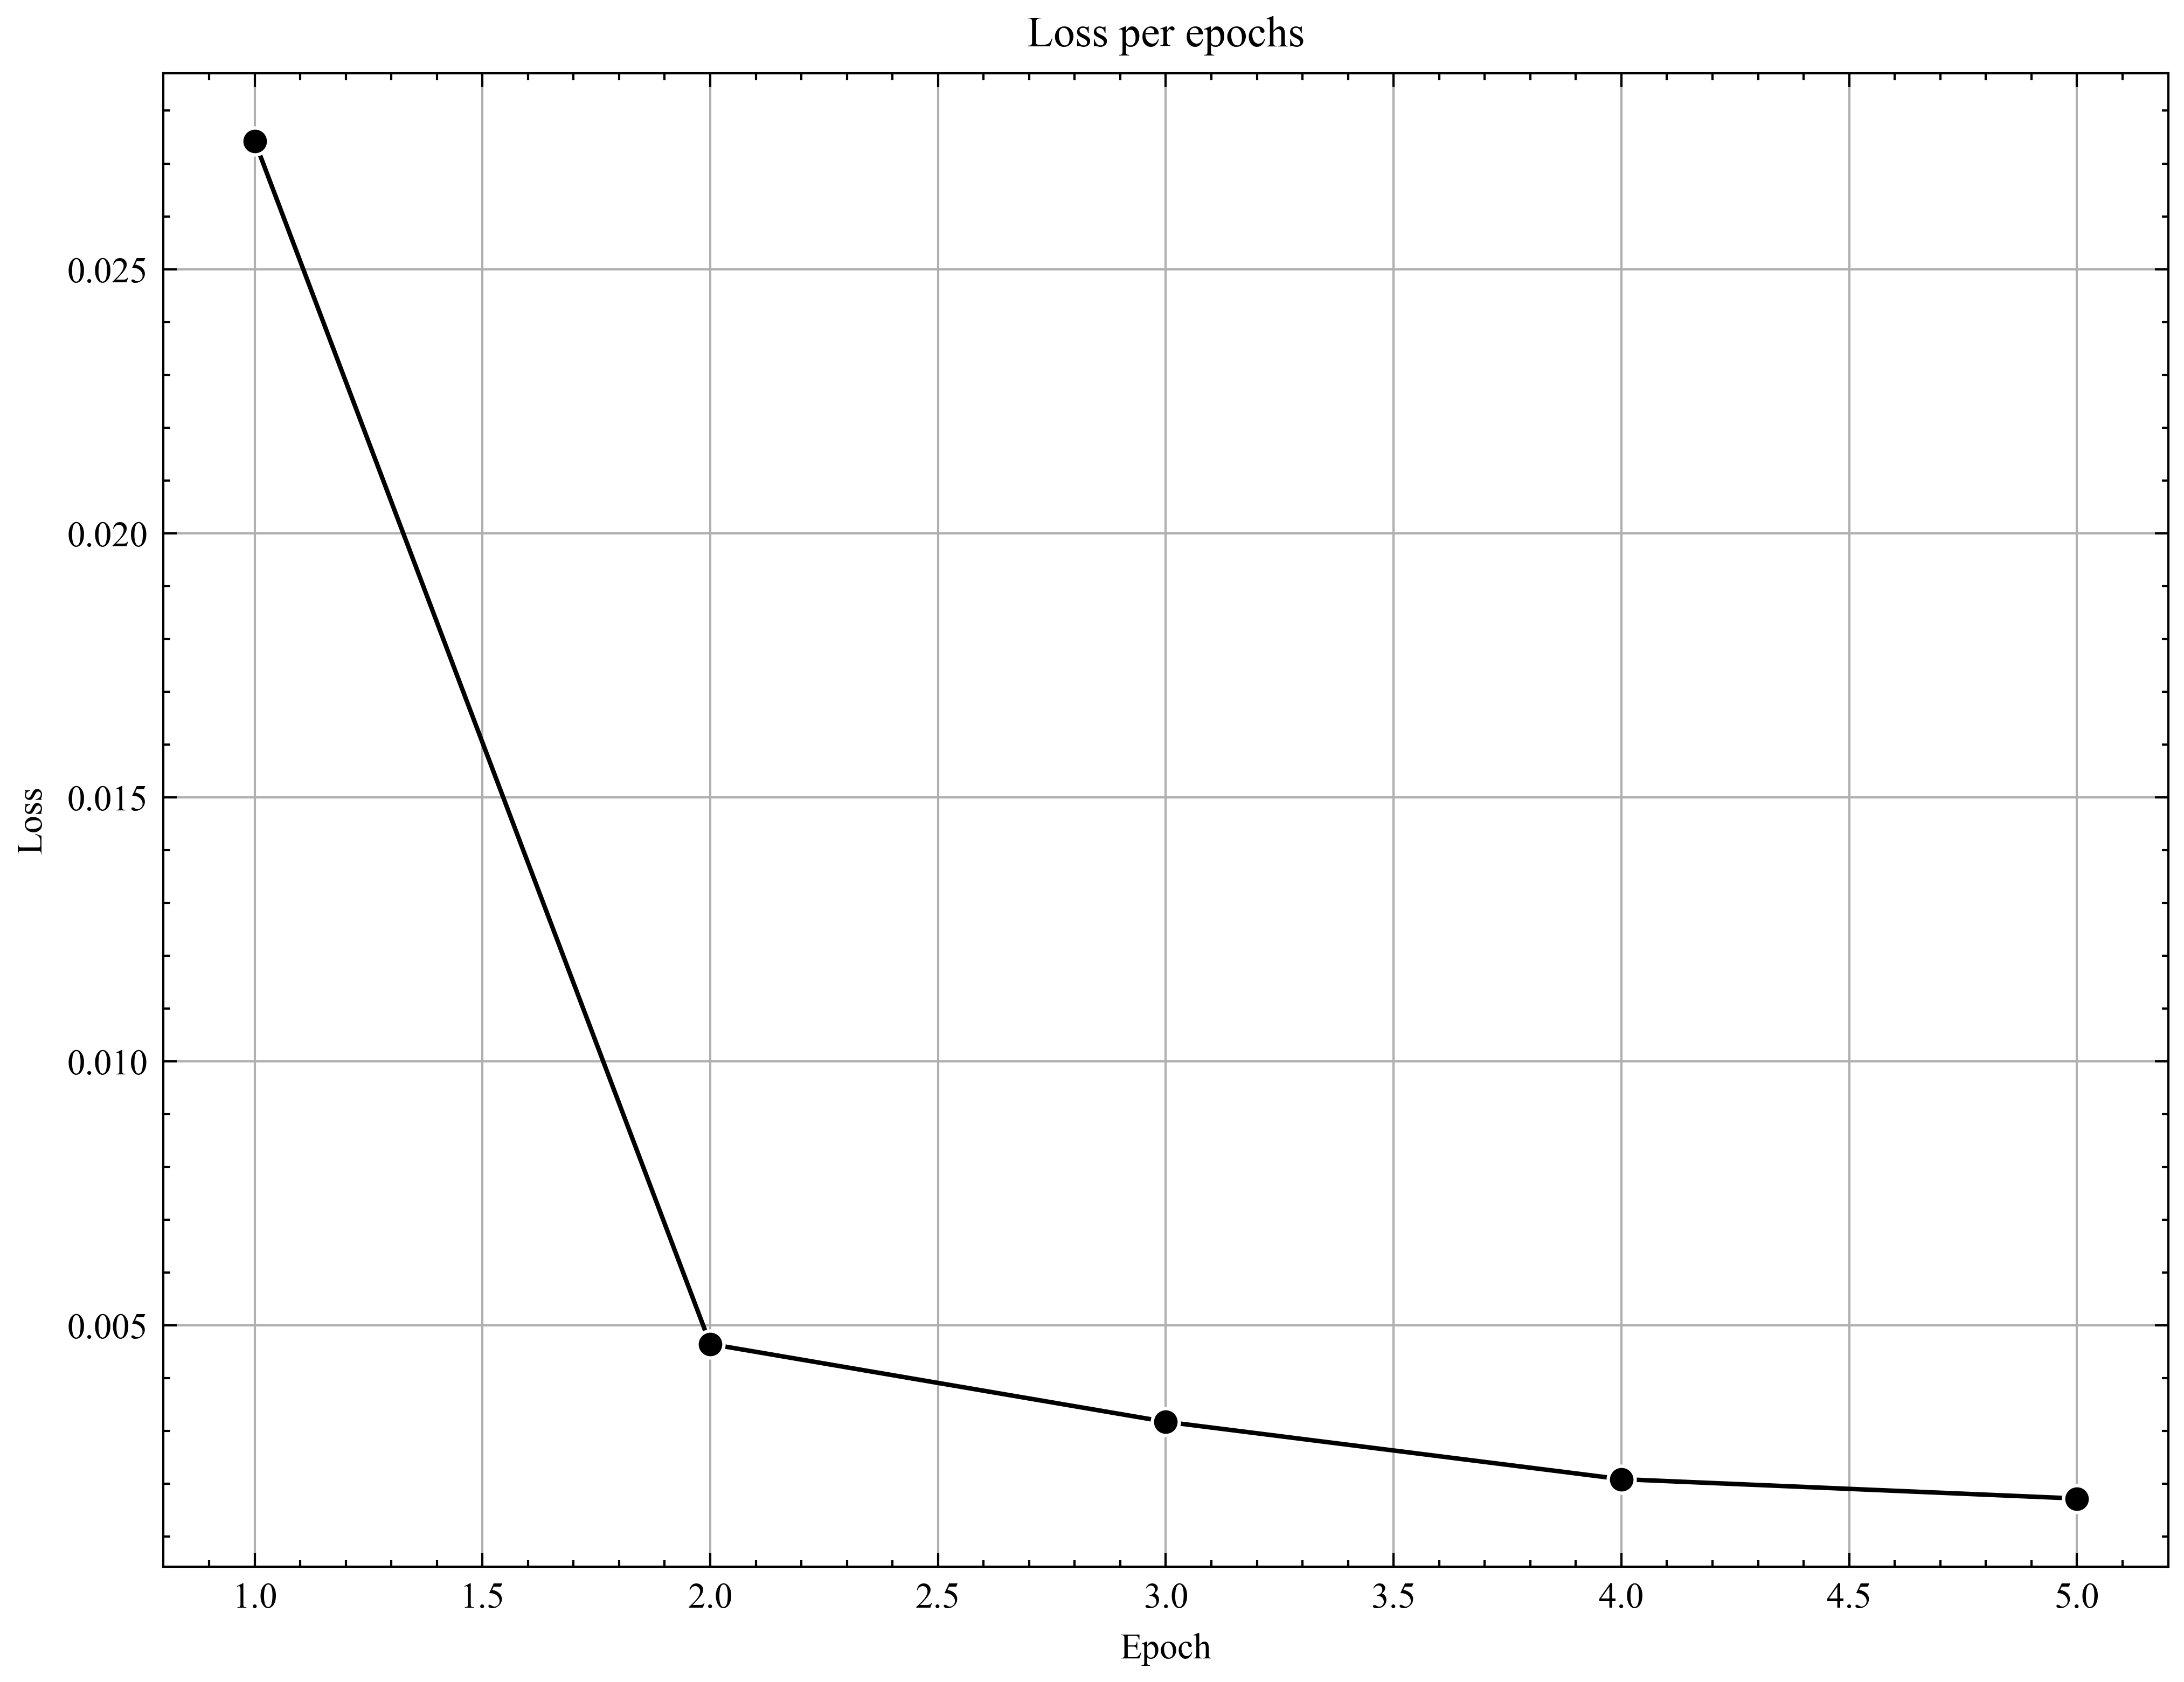

In [21]:
epochs = list(range(1, len(loss_list) + 1))

plt.figure(figsize=(8, 6))

sns.lineplot(x=epochs, y=loss_list, marker='o')

# Set labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per epochs')
plt.grid(True)
plt.show()


Loss is calculated on training data and from there threshold is calculated. Using threshold from train data and loss from test data, prediction is made. And with prediction and label data, evaluation is done.

In [22]:
testD.shape, testO.shape

(torch.Size([5000, 10, 38]), torch.Size([5000, 38]))

In [23]:
gc.collect()

143

In [44]:
### Testing phase
torch.zero_grad = True
model.eval()
print(f'{color.HEADER}Testing TranAD on SMD dataset{color.ENDC}')
loss, y_pred, attribution = backprop(0, model, testD, testO, optimizer, scheduler, training=False)

### Scores
df = pd.DataFrame()
lossT, _, _ = backprop(0, model, trainD, trainO, optimizer, scheduler, training=False)
for i in range(loss.shape[1]):
    lt, l, ls = lossT[:, i], loss[:, i], labels_loader[:, i]
    result, pred = pot_eval(lt, l, ls) 
    preds.append(pred)
    df = df.append(result, ignore_index=True)

lossTfinal, lossFinal = np.mean(lossT, axis=1), np.mean(loss, axis=1)
labelsFinal = (np.sum(labels_loader, axis=1) >= 1) + 0
result, _ = pot_eval(lossTfinal, lossFinal, labelsFinal)
result.update(hit_att(loss, labels_loader))
result.update(ndcg(loss, labels_loader))

Testing TranAD on SMD dataset
torch.Size([1, 5000, 38])


AssertionError: Cannot choose target column with output shape torch.Size([1, 5000, 38]).

In [ ]:
attribution.shape

(0,)

In [85]:
y_pred.shape

(5000, 38)

In [86]:
loss[:, 1].shape

(5000,)

In [87]:
loss.shape

(5000, 38)

In [88]:
display(df)

FN      FP   ROC/AUC      TN      TP        f1  precision    recall  \
0   1610.0     0.0  0.628004  2836.0   554.0  0.407649   1.000000  0.256007   
1      0.0     4.0  0.999404  3351.0  1645.0  0.998781   0.997574  1.000000   
2      0.0    23.0  0.996983  3789.0  1188.0  0.990408   0.981007  1.000000   
3      0.0   189.0  0.975210  3623.0  1188.0  0.926311   0.862745  1.000000   
4      0.0   142.0  0.000000  4858.0     0.0  0.000000   0.000000  0.000000   
5    554.0     0.0  0.500000  4446.0     0.0  0.000000   0.000000  0.000000   
6      0.0     0.0  1.000000  4446.0   554.0  0.999995   1.000000  1.000000   
7      0.0   100.0  0.000000  4900.0     0.0  0.000000   0.000000  0.000000   
8      0.0     1.0  0.999824  2835.0  2164.0  0.999764   0.999538  1.000000   
9      0.0     0.0  1.000000  2836.0  2164.0  0.999995   1.000000  1.000000   
10  1188.0     0.0  0.500000  3812.0     0.0  0.000000   0.000000  0.000000   
11     0.0     0.0  1.000000  2836.0  2164.0  0.999995   1.000000  1.000000   
12     0.0     0.0  1.000000  2836.0  2164.0  0.999995   1.000000  1.000000   
13     0.0     1.0  0.999824  2835.0  2164.0  0.999764   0.999538  1.000000   
14     0.0     0.0  1.000000  2836.0  2164.0  0.999995   1.000000  1.000000   
15  1188.0     0.0  0.500000  3812.0     0.0  0.000000   0.000000  0.000000   
16     0.0   830.0  0.000000  4170.0     0.0  0.000000   0.000000  0.000000   
17     0.0   686.0  0.000000  4314.0     0.0  0.000000   0.000000  0.000000   
18     0.0    27.0  0.996964  4419.0   554.0  0.976206   0.953528  1.000000   
19     0.0     0.0  1.000000  4446.0   554.0  0.999995   1.000000  1.000000   
20     0.0    16.0  0.998201  4430.0   554.0  0.985760   0.971930  1.000000   
21     0.0    62.0  0.993027  4384.0   554.0  0.947004   0.899351  1.000000   
22     0.0     7.0  0.000000  4993.0     0.0  0.000000   0.000000  0.000000   
23     0.0   327.0  0.963225  4119.0   554.0  0.772121   0.628831  1.000000   
24     0.0   109.0  0.985703  3703.0  1188.0  0.956132   0.915960  1.000000   
25     0.0     1.0  0.999888  4445.0   554.0  0.999093   0.998198  1.000000   
26     0.0   643.0  0.927688  3803.0   554.0  0.632777   0.462824  1.000000   
27     0.0    15.0  0.998033  3797.0  1188.0  0.993721   0.987531  1.000000   
28     0.0   277.0  0.968848  4169.0   554.0  0.799995   0.666667  1.000000   
29     0.0  1637.0  0.815902  2809.0   554.0  0.403640   0.252853  1.000000   
30     0.0   109.0  0.987742  4337.0   554.0  0.910431   0.835596  1.000000   
31     0.0    91.0  0.989766  4355.0   554.0  0.924098   0.858915  1.000000   
32     0.0   538.0  0.939496  3908.0   554.0  0.673143   0.507326  1.000000   
33     0.0     8.0  0.999100  4438.0   554.0  0.992827   0.985765  1.000000   
34     0.0    62.0  0.993027  4384.0   554.0  0.947004   0.899351  1.000000   
35     0.0    54.0  0.993927  4392.0   554.0  0.953523   0.911184  1.000000   
36     0.0   767.0  0.000000  4233.0     0.0  0.000000   0.000000  0.000000   
37     0.0   783.0  0.000000  4217.0     0.0  0.000000   0.000000  0.000000   

    threshold  
0    0.225386  
1    0.053272  
2    0.017966  
3    0.015398  
4    0.000642  
5    0.822621  
6    0.084602  
7    0.000687  
8    0.005832  
9    0.008424  
10   0.824323  
11   0.274179  
12   0.040064  
13   0.007017  
14   0.097634  
15   0.770815  
16   0.000225  
17   0.000395  
18   0.010074  
19   0.039115  
20   0.023374  
21   0.023844  
22   0.059849  
23   0.000608  
24   0.010665  
25   0.001041  
26   0.000241  
27   0.018601  
28   0.000235  
29   0.000350  
30   0.022595  
31   0.031307  
32   0.000286  
33   0.000518  
34   0.033621  
35   0.034050  
36   0.000263  
37   0.000233

In [89]:
pprint(result)

{'FN': 0,
 'FP': 0,
 'Hit@100%': 0.5056248775522373,
 'Hit@150%': 0.6497804990757856,
 'NDCG@100%': 0.5259027399006211,
 'NDCG@150%': 0.6132862626808705,
 'ROC/AUC': 1.0,
 'TN': 2836,
 'TP': 2164,
 'f1': 0.9999949954039277,
 'precision': 0.9999999953789278,
 'recall': 0.9999999953789278,
 'threshold': 0.031146135595749018}


In [34]:
np.array(preds).shape

(76, 28479)

In [37]:
final_preds = np.array([[np.float32(value) for value in sublist] for sublist in preds]).T
final_preds.shape

(28479, 76)

### Visualizations

#### Training data

In [40]:
len(final_preds[0]), final_preds

(76,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [36]:
train_data = train['machine-1-1_train']

fig, axs = plt.subplots(5, 1, figsize=(15, 12))

channels = np.random.choice(range(38), size=5, replace=False)

for i, c in enumerate(channels):
    axs[i].plot(train_data[:, c], label=f'Channel {c}')
    axs[i].set_title(f'Channel {c}', fontsize=12)
    axs[i].set_xlabel('Time', fontsize=10)
    axs[i].set_ylabel('Value', fontsize=10)
    axs[i].grid(True)

fig.suptitle('Random channels from training data', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


#### Testing data

In [47]:
test_data = test['machine-1-1_test']
true_labels = labels['machine-1-1_labels']
predicted_labels = final_preds

# Select channels to plot
selected_channels = [0, 2, 5, 8, 9, 11, 15, 30]

# Plotting
fig, axes = plt.subplots(len(selected_channels), 1, figsize=(15, 20), sharex=True)
time_steps = np.arange(test_data.shape[0])

for i, channel in enumerate(selected_channels):
    axes[i].plot(time_steps, test_data[:, channel])
    axes[i].fill_between(time_steps, 0, 0.5, where=true_labels[:, channel] == 1, color='red', alpha=0.5, label='True Anomaly')
    axes[i].fill_between(time_steps, 0.5, 1, where=predicted_labels[:, channel] == 1, color='blue', alpha=0.3, label='Predicted Anomaly')
    axes[i].set_title(f'Channel {channel}', fontsize=12)
    axes[i].set_xlabel('Time', fontsize=10)
    axes[i].set_ylabel('Value', fontsize=10)
    axes[i].grid(True)
    axes[i].legend()

fig.suptitle('Testing data with true anomaly and predicted anomaly', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()